In [ ]:
!pip install gradio PyMuPDF nltk rank_bm25 transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 38.1 MB/s eta 0:00:00


In [ ]:
import fitz  # PyMuPDF
import nltk
import gradio as gr
from nltk.tokenize import word_tokenize
from rank_bm25 import BM25Okapi
from transformers import pipeline, AutoTokenizer

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

###Processamento - igual o app.py
Extração do texto, chunkenização e indexação com BM25.

In [ ]:
def extrair_texto_pdf(caminho_pdf):
    doc = fitz.open(caminho_pdf)
    texto = ""
    for pagina in doc:
        texto += pagina.get_text()
    return texto

def preparar_paragrafos(texto, chunk_size=500, chunk_overlap=50):
    chunks = []
    for i in range(0, len(texto), chunk_size - chunk_overlap):
        chunk = texto[i:i + chunk_size]
        if len(chunk.strip()) > 50:
            chunks.append(chunk.strip())
    return chunks

def tokenizar_paragrafos(paragrafos):
    return [word_tokenize(p.lower()) for p in paragrafos]

def configurar_bm25(tokenizados):
    return BM25Okapi(tokenizados)

### Carregamento do Modelo T5-LARGE + Prompt

In [ ]:
def carregar_modelo():
    tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
    model_pipeline = pipeline(
        "text2text-generation",
        model="google/flan-t5-large",
        tokenizer=tokenizer,
        device=-1
    )
    return model_pipeline, tokenizer

def responder(pergunta, bm25, paragrafos, modelo_e_tokenizer, top_n=5, max_context_tokens=400):
    modelo, tokenizer = modelo_e_tokenizer
    tokens_pergunta = word_tokenize(pergunta.lower())
    documentos_recuperados = bm25.get_top_n(tokens_pergunta, paragrafos, n=top_n)

    contexto_final = []
    current_tokens = 0
    for doc in documentos_recuperados:
        doc_tokens = tokenizer.encode(doc, add_special_tokens=False)
        if current_tokens + len(doc_tokens) > max_context_tokens:
            break
        contexto_final.append(doc)
        current_tokens += len(doc_tokens)

    contexto = " ".join(contexto_final)

    prompt = f"""
    Você é um assistente educacional. Use apenas o CONTEXTO abaixo para responder à PERGUNTA com clareza e naturalidade, escrevendo em português fluente.
    Seja direto, mas explique bem, como se estivesse ensinando a um estudante brasileiro.

    CONTEXTO:
    {contexto}

    PERGUNTA:
    {pergunta}

    RESPOSTA:
    """

    resposta = modelo(prompt, max_new_tokens=300, do_sample=False)
    return resposta[0]["generated_text"].strip()

### Inicialização dos Dados e Transformers

In [ ]:
pdf_path = "PPC-LC-atualizao.pdf"
texto = extrair_texto_pdf(pdf_path)
paragrafos = preparar_paragrafos(texto)
tokenizados = tokenizar_paragrafos(paragrafos)
bm25 = configurar_bm25(tokenizados)
modelo, tokenizer = carregar_modelo()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cpu


### Deploy no Gradio
Como o modelo é grande, a resposta pode acabar ficando um pouco grande.

Execute o código no Colab e copie o link gerado do Gradio.
O link abre uma interface Web com um campo de input e output do modelo acerca do PPC.

A primeira iteração durante os testes costumou demorar aproximadamente 173 segundos, mas achamos o modelo melhor do que o que disponibilizamos no Streamlit.

In [ ]:
def interface_gradio(pergunta):
    resposta = responder(pergunta, bm25, paragrafos, (modelo, tokenizer))
    return resposta

gr.Interface(
    fn=interface_gradio,
    inputs=gr.Textbox(label="Pergunta sobre o PPC"),
    outputs=gr.Textbox(label="Resposta do Chatbot"),
    title="📘 Chatbot RAG - PPC Licenciatura em Computação (UFRPE)",
    description="Faça perguntas sobre o Projeto Pedagógico do Curso. As respostas são geradas com base no documento oficial (via RAG)."
).launch()

O GitHub não suporta o Widget do Gradio, então para rodar deve abrir o colab, colar a ementa e executar a cédula do gradio, que será assim:


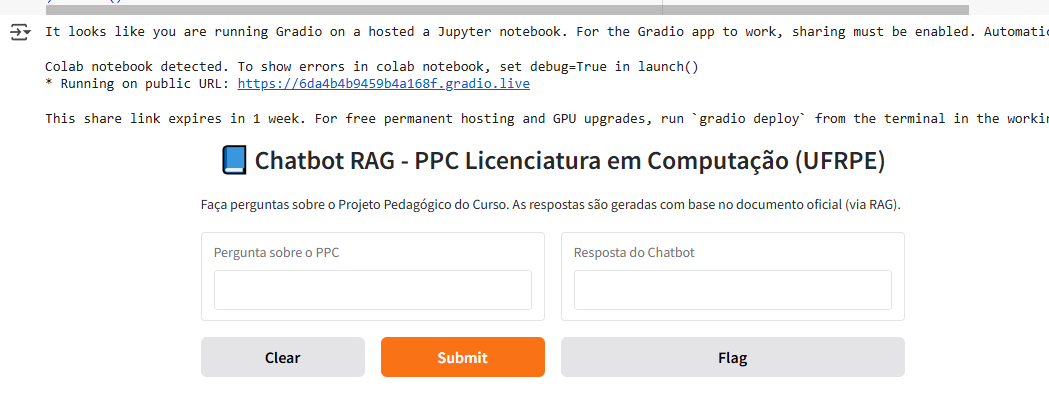